In [ ]:
# Automatically reloads imported files: this is not done manually by ipynb; this magic command tells the compiler that each time we update an imported file we want to reload it
%load_ext autoreload
# Reload all modules before executing code
%autoreload 2

#change
#temp

In [ ]:
import sys,os

sys.path.append(os.getcwd())



In [ ]:
import tensorflow as tf 

tf.__version__

In [ ]:
#Spip list | grep tensorflow
import sys,os
sys.path.append(os.getcwd())
from main import DL


In [ ]:
test = DL()

In [24]:
test.importData(isTesting = True)

Listing .mat files for: TestingData
TestingData//20250331_LiquidPhantomValidations/6mm_Submarine _Crop_test/DL_nImages1.mat
TestingData//20250331_LiquidPhantomValidations/6mm_Submarine_Crop_test/DL_nImages1.mat
TestingData/0250530_DT_MCX_SFDI/0250530_Tumour3_DT_comparison/DL_nImages4.mat
TestingData/0250530_DT_MCX_SFDI/0250530_Tumour3_MCX_1e8_comparison/DL_nImages4.mat
TestingData/0250530_DT_MCX_SFDI/0250530_Tumour3_MCX_1e8_comparison/DL_nImages4_padded.mat
TestingData/0250530_DT_MCX_SFDI/CT_SFDI_Combined/DL_nImages4.mat
TestingData/0250530_DT_MCX_SFDI/DT_lower_optprop/DL_nImages4.mat
TestingData/0250530_DT_MCX_SFDI/comparison_DT_MCX_SFDI_concatenated_data.mat
TestingData/1000_CSH_DTOP_4_6/DL_nImages1000.mat
TestingData/1003_nocodeshift_fordebug/DL_nImages1000 (2).mat
TestingData/1004_CSH_0_10_DTOP_1000/DL_nImages1000.mat
TestingData/1127_Mandolin_Tumours_210_1_10_shift/Parameters.mat
TestingData/1127_Mandolin_Tumours_210_1_10_shift/nImages210.mat
TestingData/1127_Mandolin_Tumours_210_

In [ ]:
test.Train()


In [ ]:
test.upload_to_S3()

In [ ]:
test.load()


In [ ]:
test.Plot()

In [ ]:
test.modelD.summary()

In [ ]:
for layer in test.modelD.layers:
    if isinstance(layer, tf.keras.layers.Dropout):
        print(f"Dropout rate in layer '{layer.name}': {layer.rate}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # Create a 1x6 grid of subplots with a specific size

for i in range(6):
    ax = axes[i]  # Access each axis
    img_data = np.squeeze(test.FL[0, :, :, i, 0])
    img = ax.imshow(img_data,vmin=np.min(img_data), vmax=np.max(img_data), cmap='jet')  # Display the image
    ax.axis('off')  # Turn off both axes and ticks

    cbar = fig.colorbar(img, ax=ax, shrink=0.8)  # Shrink the colorbar to 80% of its size

plt.show()

In [ ]:
test.Analysis(save_image = 0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score

# Set font properties
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 20}
matplotlib.rc('font', **font)

# Simulated THb values for each group (Group 1 = 5 g/L, Group 2 = 65 g/L)
THb_values = [60]  # Group 1 and Group 2

# Example: Replace these with your actual data extraction from the model
predict = test.modelD.predict([test.OP, test.FL], batch_size=32)
QF_P = predict[0]
DF_P = predict[1]
DFP_min = test.get_min(DF_P)
true_depths = test.get_min(test.DF)

# Flatten arrays
predicted_depths = DFP_min.flatten()
true_depths = true_depths.flatten()

# Assign THb group to each sample
group_assignments = [THb_values[i % len(THb_values)] for i in range(len(true_depths))]

# Compute metrics per group
results = {}

for group in THb_values:
    indices = [i for i, g in enumerate(group_assignments) if g == group]
    
    pred = predicted_depths[indices]
    true = true_depths[indices]

    r2_indices = [i for i, g in enumerate(group_assignments) if g == group and true_depths[i] > 5]

    r2_pred = predicted_depths[r2_indices]
    r2_true = true_depths[r2_indices]
    
    r2 = r2_score(r2_true, r2_pred)
    errors = np.abs(r2_true - r2_pred)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    

    results[group] = {
        'R2 Score': r2,
        'Mean Depth Error': mean_error,
        'Std of Error': std_error
    }

    # Print results
    for group, metrics in results.items():
        print(f"Group THb = {group} g/L")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        print()

    r2_indices = [i for i, g in enumerate(group_assignments) if g == group and true_depths[i] < 5]

    r2_pred = predicted_depths[r2_indices]
    r2_true = true_depths[r2_indices]
    
    r2 = r2_score(r2_true, r2_pred)
    errors = np.abs(r2_true - r2_pred)
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    

    results[group] = {
        'R2 Score': r2,
        'Mean Depth Error': mean_error,
        'Std of Error': std_error
    }

    # Print results
    for group, metrics in results.items():
        print(f"Group THb = {group} g/L")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        print()

# ---- Plotting ----
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Plotting ----
plt.figure(figsize=(7, 5))

# Define colors and labels
group_colors = {60: 'red'}
group_labels = {60: 'THb Conc = 30 g/L'}

# Plot small scatter points
for i in range(len(DFP_min)):
    plt.scatter(true_depths[i], predicted_depths[i], s=3, color='red')

# Plot identity line
plt.plot([0, 10], [0, 10], linestyle='dashed', linewidth=3, color='blue')
# Custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='THb Conc = 30 g/L',
           markerfacecolor='red', markersize=10)  # Bigger red dot for legend
]

# Set axis limits and labels
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.ylabel("Predicted Depth (mm)")
plt.xlabel("True Depth (mm)")

# Add custom legend
plt.legend(handles=legend_elements, loc='upper left', fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib

# Set font properties
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 20}
matplotlib.rc('font', **font)

THb_values = [1.5, 10 , 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Example THb values

predict = test.modelD.predict([test.OP, test.FL], batch_size=32)

QF_P = predict[0]
DF_P = predict[1]
DFP_min = test.get_min(DF_P)

predicted_depths = DFP_min

# Create figure
thb_depth_graph = plt.figure(figsize=(7, 5))

# Plot the predicted depths vs. THb
plt.scatter(THb_values, predicted_depths, s=15, color='red')

# Set x and y limits
plt.xlim([0, 100])
plt.ylim([0, 10])

# Set custom x-axis ticks
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Plot horizontal ground truth line at y = 5 mm
plt.axhline(y=5, color='blue', linestyle='dashed', linewidth=3)

# Axis labels
plt.xlabel("Total Hemoglobin Concentration (g/L)")
plt.ylabel("Predicted Depth (mm)")

# No legend
# plt.legend() ← intentionally left out

# Layout adjustment
plt.tight_layout()

# Show the figure
thb_depth_graph.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

# Set font properties for axis labels and title
font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 20}
matplotlib.rc('font', **font)

# ROI and offset settings
roi_size = 5
half = roi_size // 2
offset = 10  # Move background ROI inward from edges

F = test.FL  # Your 4D image array (N, H, W, C)

tbr_values = []

# Calculate TBR for each image
for i in range(F.shape[0]):
    image = F[i, :, :, 0]
    rows, cols = image.shape

    center_row = rows // 2
    center_col = cols // 2
    center_roi = image[center_row - half:center_row + half + 1,
                       center_col - half:center_col + half + 1]
    center_mean = np.mean(center_roi)

    top_left     = image[offset:offset + roi_size, offset:offset + roi_size]
    top_right    = image[offset:offset + roi_size, cols - offset - roi_size:cols - offset]
    bottom_left  = image[rows - offset - roi_size:rows - offset, offset:offset + roi_size]
    bottom_right = image[rows - offset - roi_size:rows - offset, cols - offset - roi_size:cols - offset]

    corner_mean = np.mean(np.concatenate([
        top_left.flatten(),
        top_right.flatten(),
        bottom_left.flatten(),
        bottom_right.flatten()
    ]))

    tbr = center_mean / corner_mean if corner_mean != 0 else np.nan
    tbr_values.append(tbr)

# Example THb values (make sure length matches tbr_values)
THb_values = [1.5, 10 , 20, 30, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(7, 5))

# Plot TBR vs THb with blue line connecting points
plt.plot(THb_values, tbr_values, marker='o', color='blue', linewidth=2)

# X-axis ticks and limits
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlim([0, 100])

# Y-axis limits and ticks with 0.25 spacing for compactness
plt.ylim([1, 3])
plt.yticks(np.arange(1, 3.01, 0.5))  # slightly smaller font for ticks

# # Optionally reduce x-axis tick font size too
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.xlabel("Total Hemoglobin Concentration (g/L)")
plt.ylabel("Image TBR")

plt.tight_layout()
plt.show()


In [ ]:
#plots RE 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

raw_RE = test.RE
save_fig = 0
save_path = os.path.join('./predictions/' + test.folder_name)
for x in range(test.RE.shape[0]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # Create a 1x6 grid of subplots with a specific size

    for i in range(6):
        ax = axes[i]
        img_data = np.squeeze(raw_RE[x, :, :, i])
        
        # Display image with percentile-based scaling
        img = ax.imshow(
            img_data,
            vmin=np.percentile(img_data, 2.5),
            vmax=np.percentile(img_data, 97.5),
            cmap='jet'
        )
        ax.axis('off')

        # Create colorbar with compact scientific formatting
        cbar = fig.colorbar(img, ax=ax, shrink=0.8)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))  # Adjust as needed
        cbar.formatter = formatter
        cbar.ax.yaxis.set_offset_position('left')  # Moves exponent to top of vertical bar
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=6)

    #optionally, save the figures
    if save_fig:
        plot_save_path_FL = save_path + '_depth_' + str(x) +'_RE.png'
        plt.savefig(plot_save_path_FL, dpi=100, bbox_inches='tight')


    plt.tight_layout()
    plt.show()


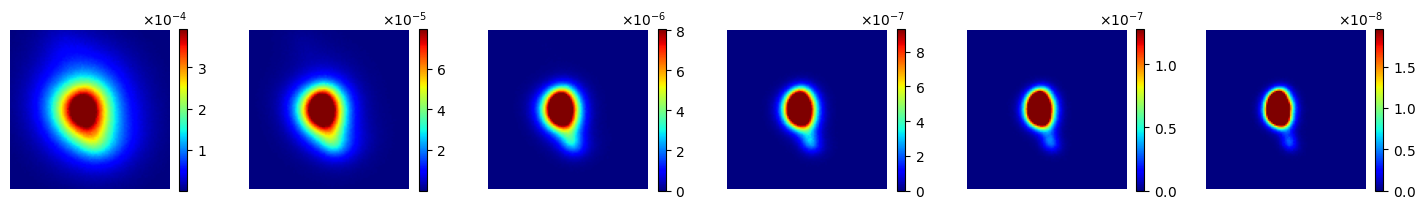

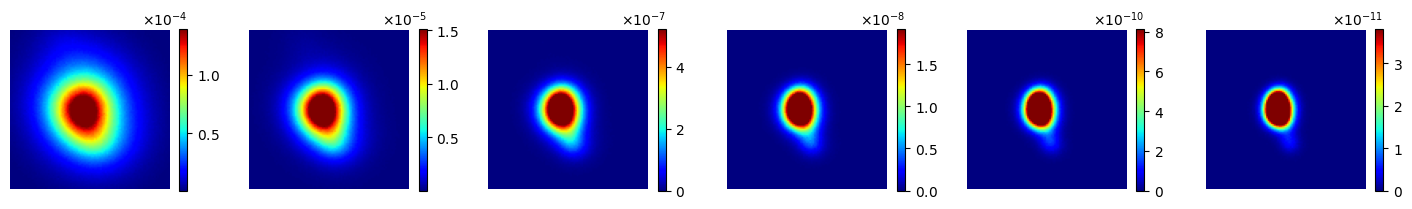

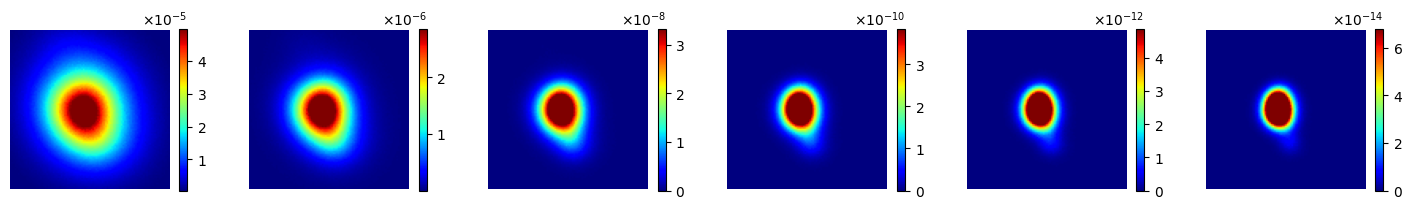

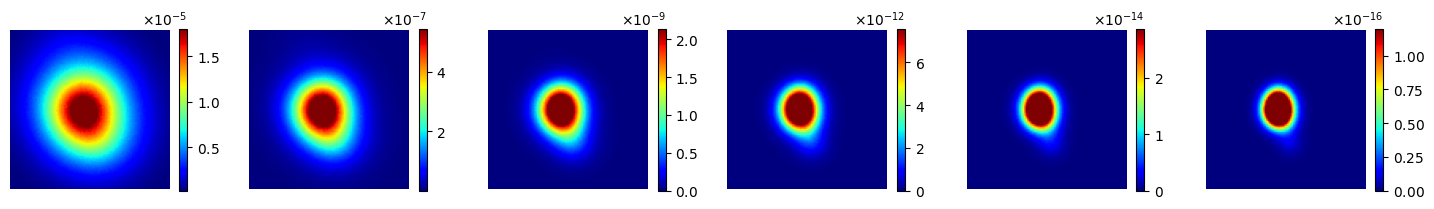

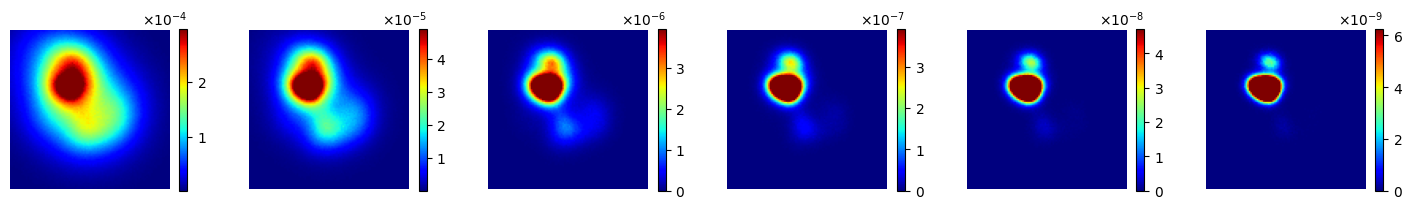

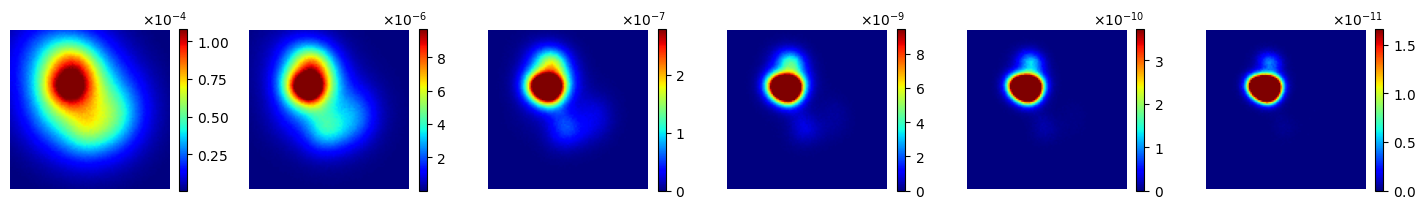

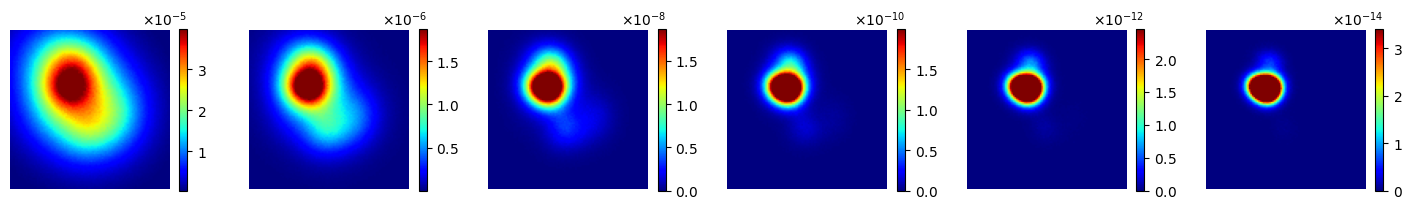

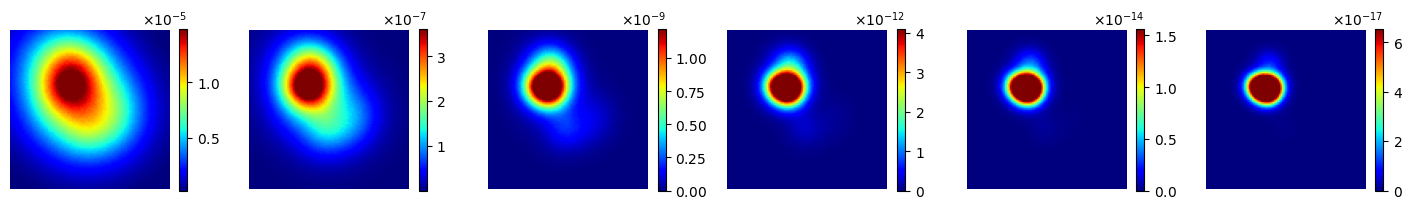

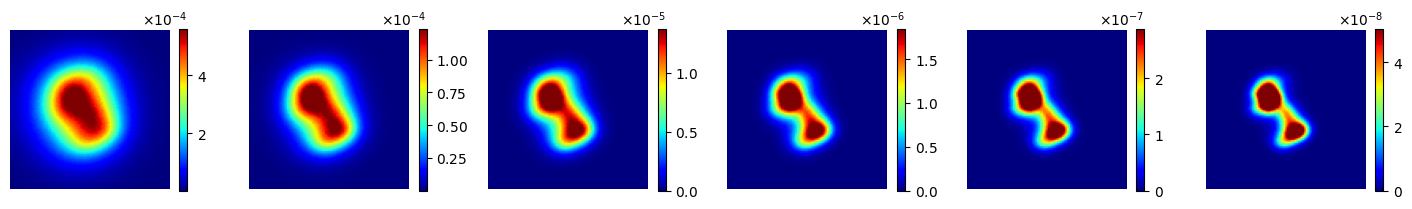

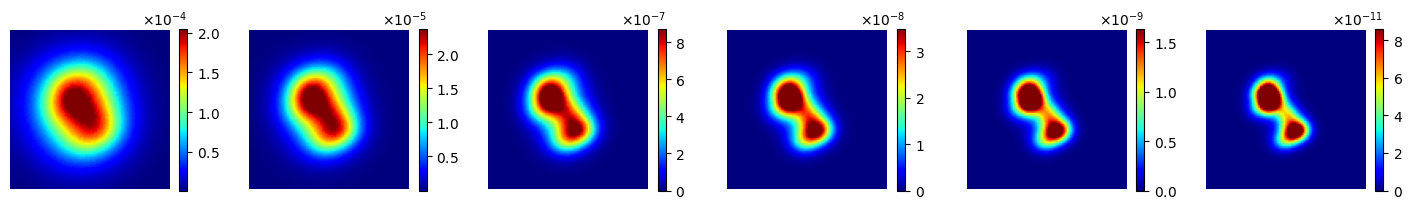

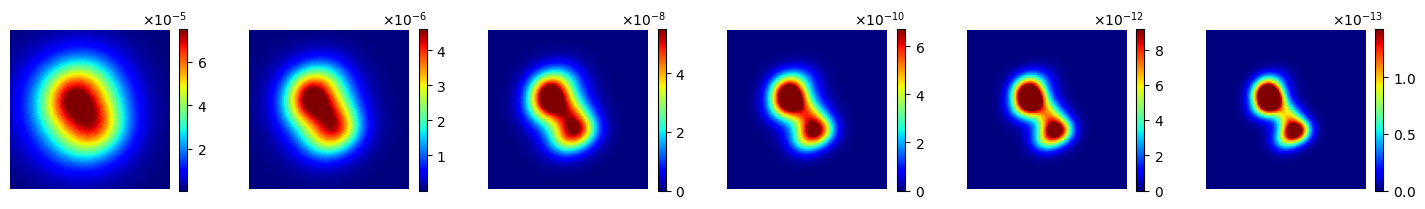

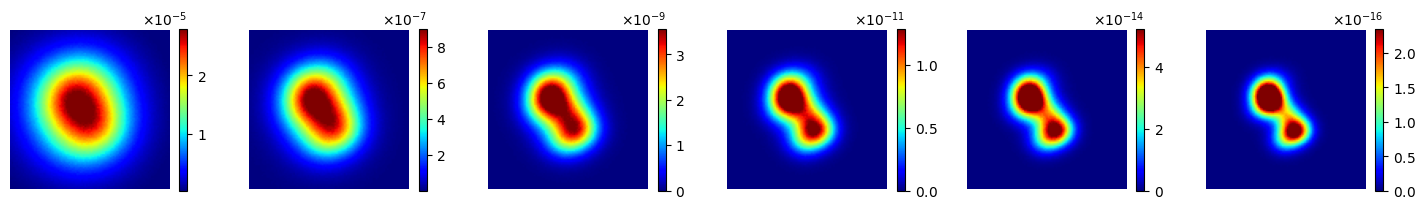

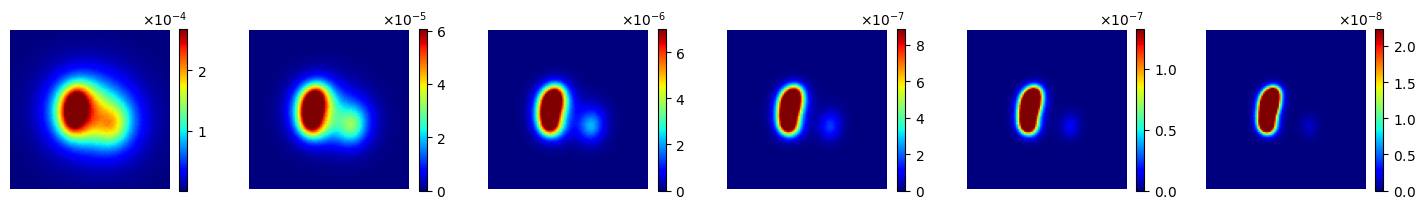

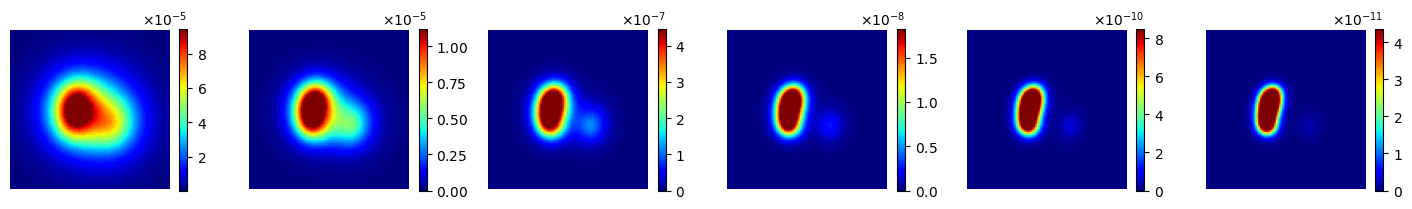

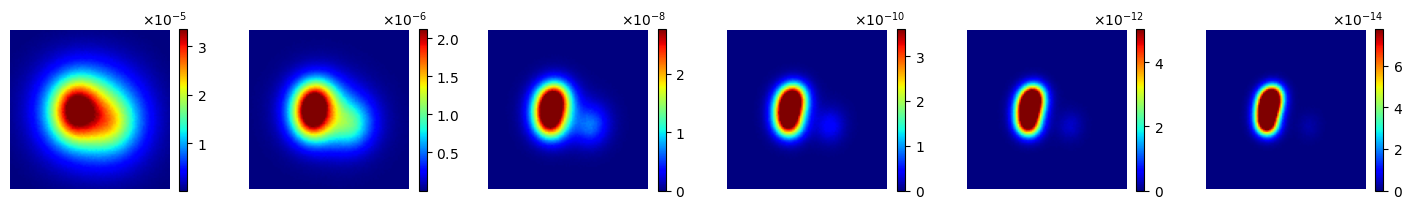

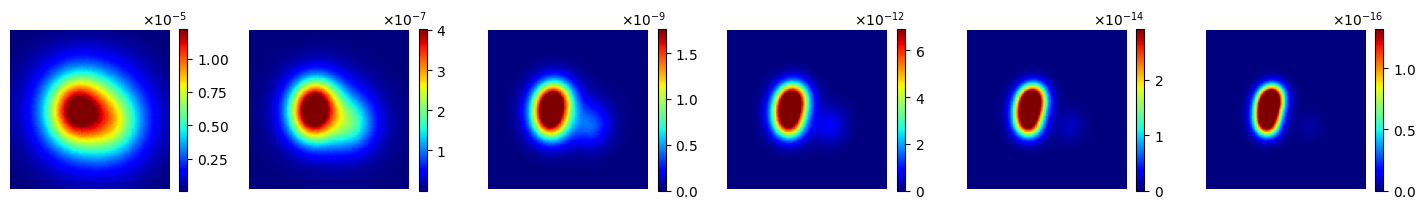

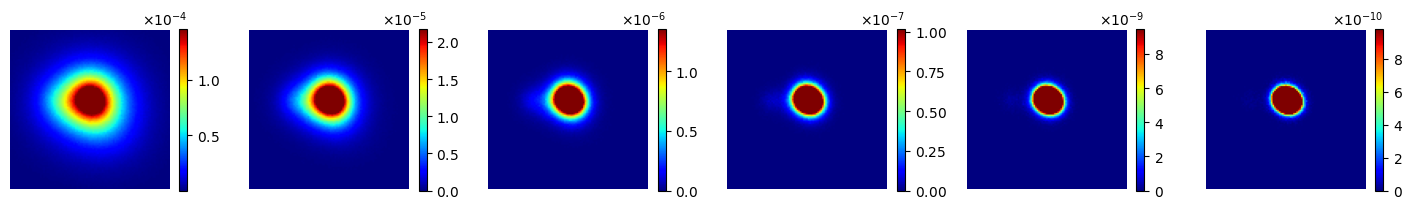

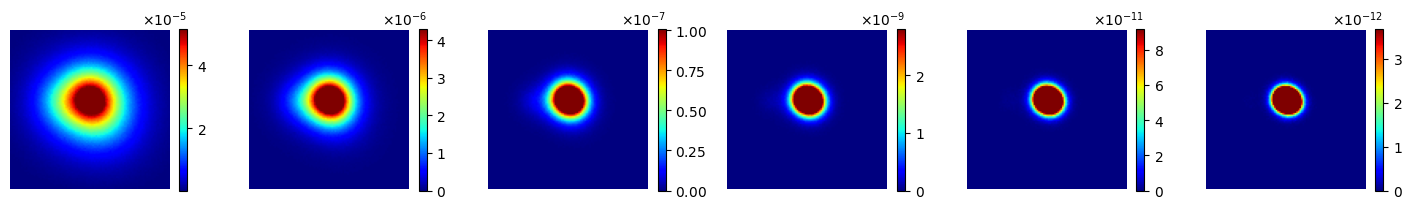

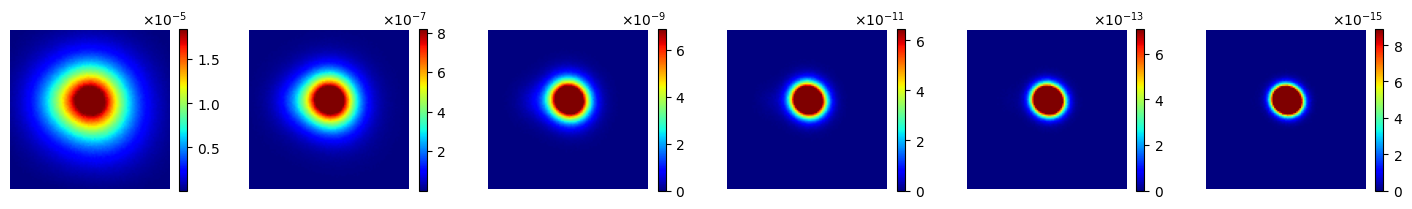

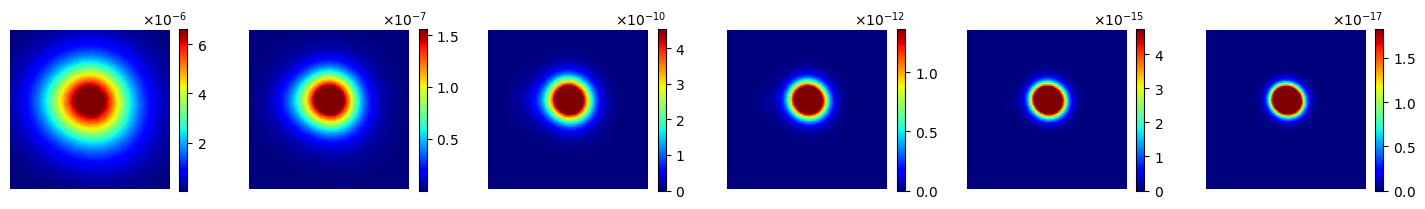

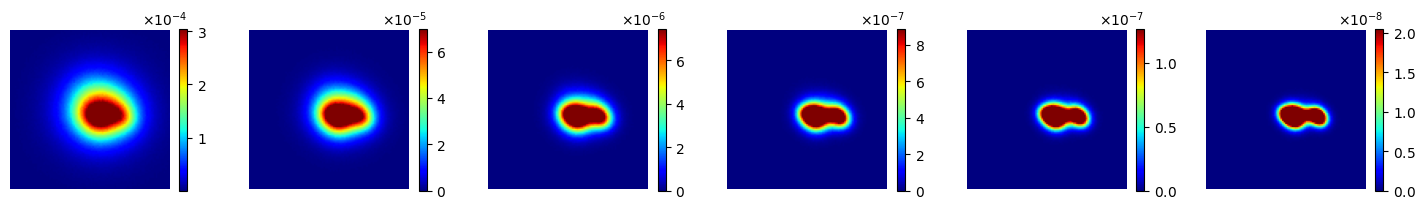

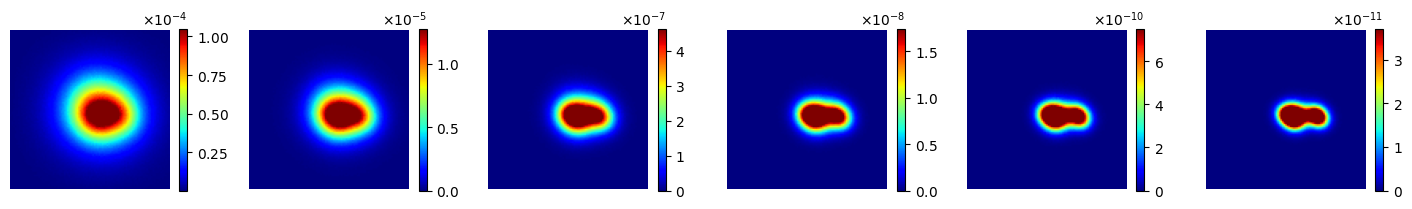

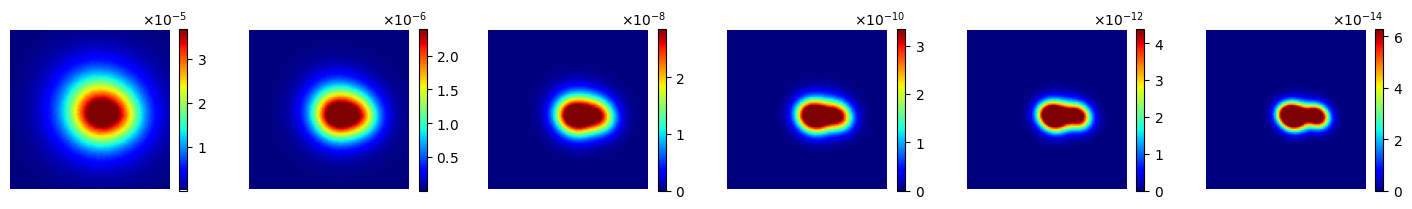

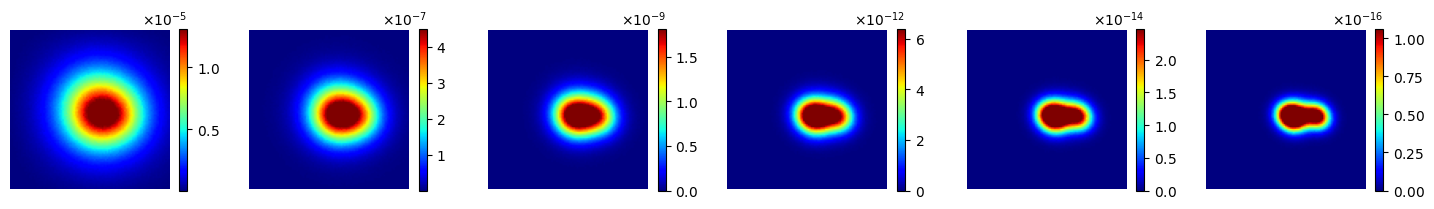

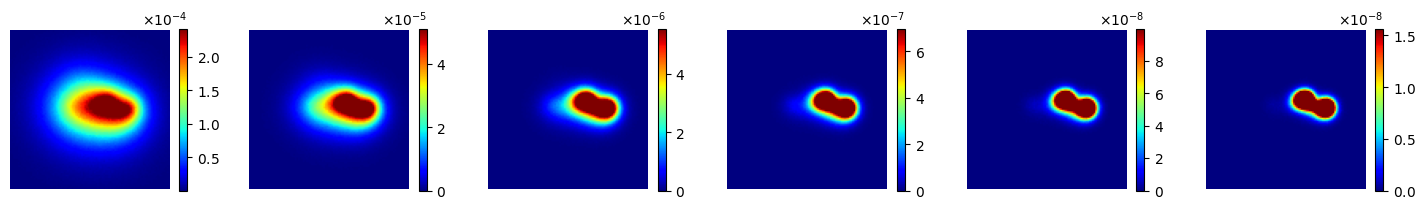

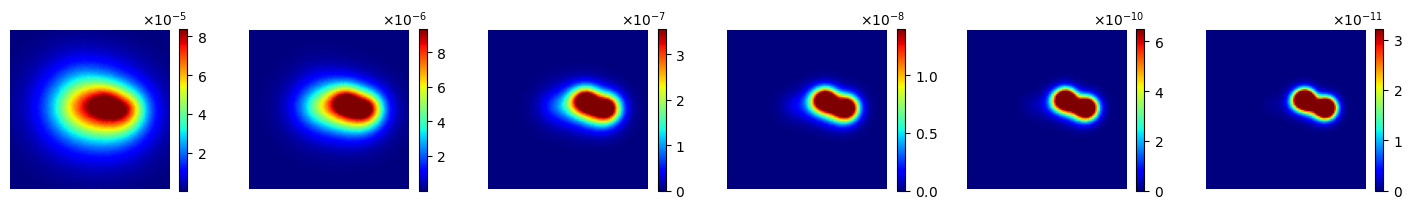

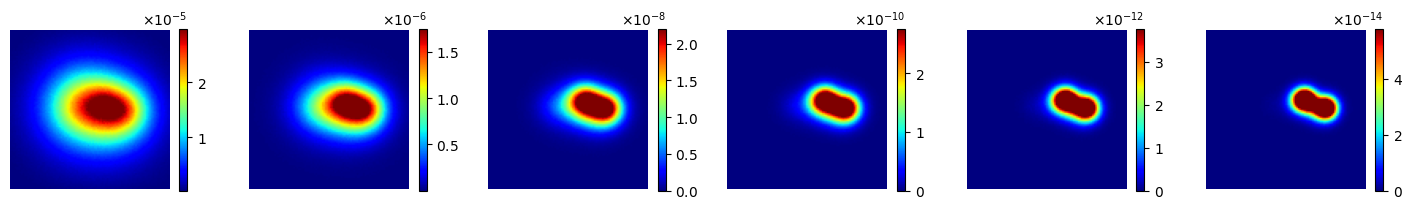

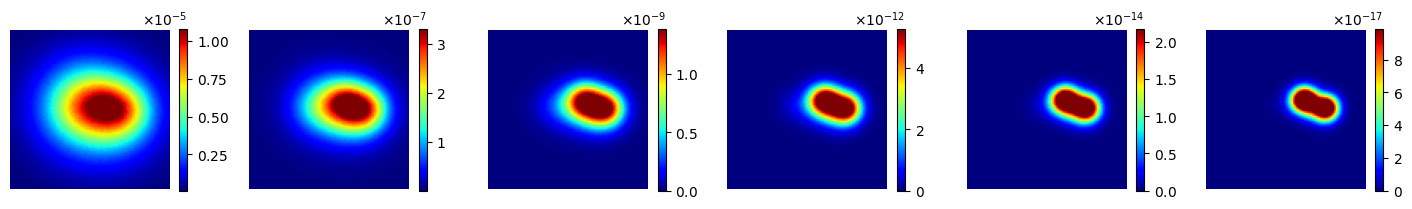

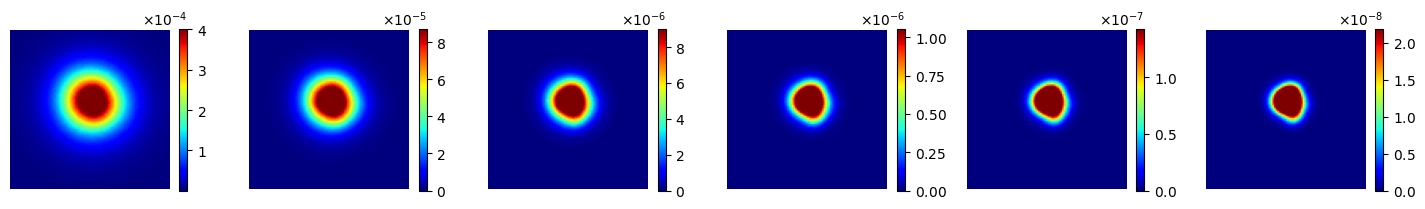

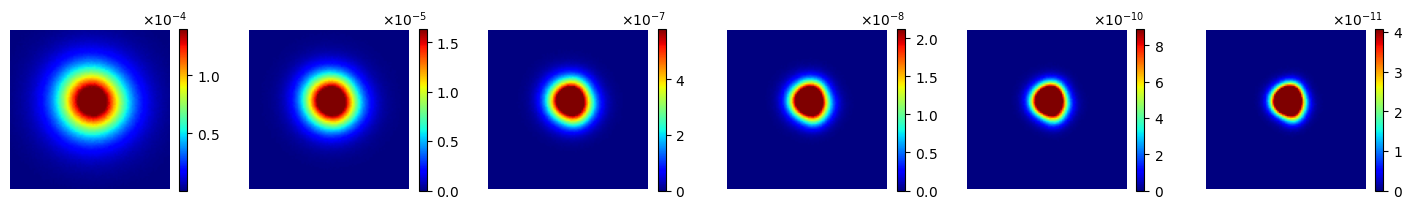

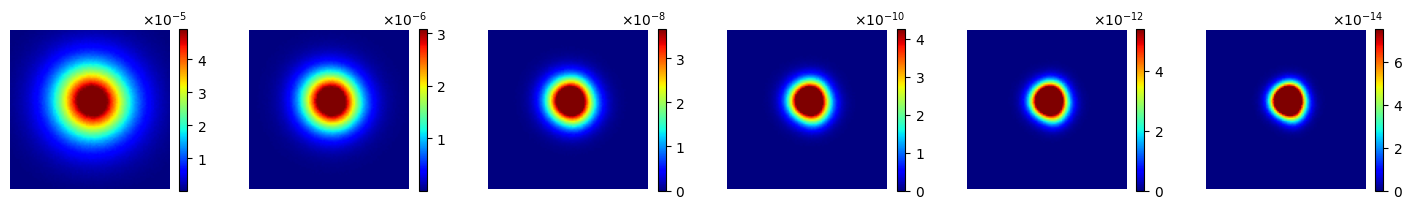

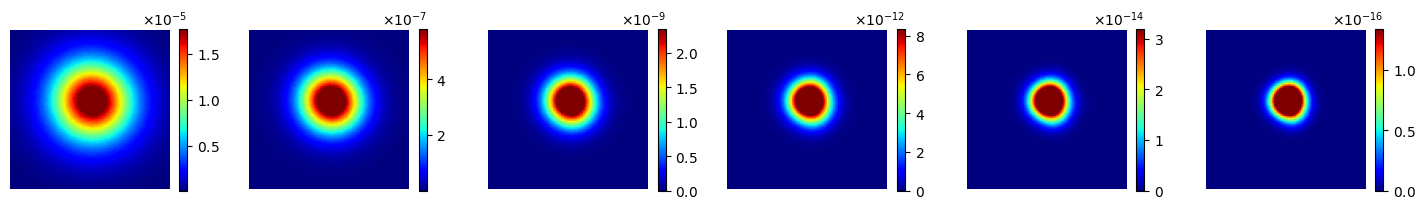

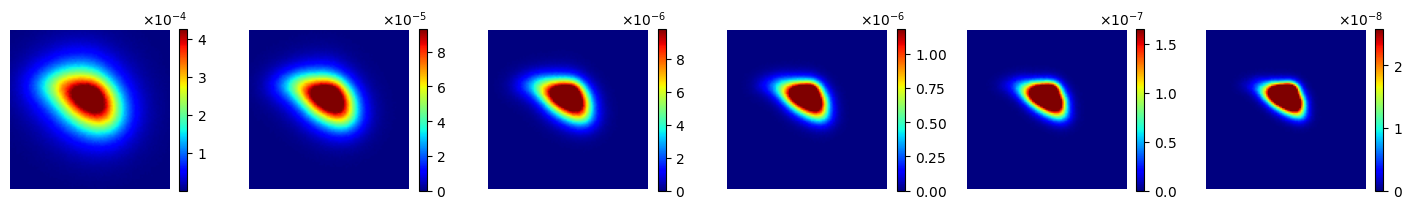

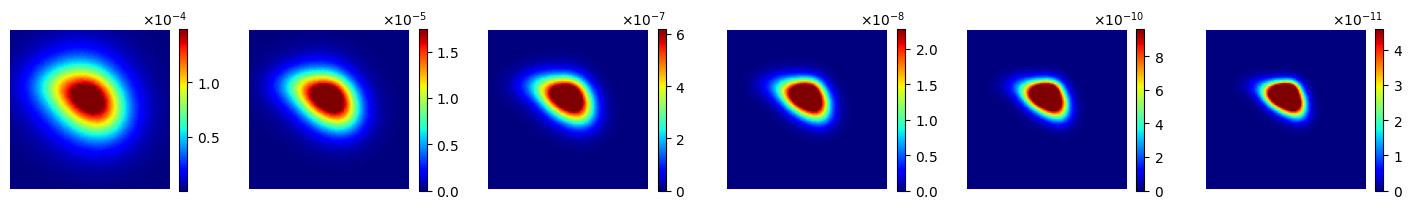

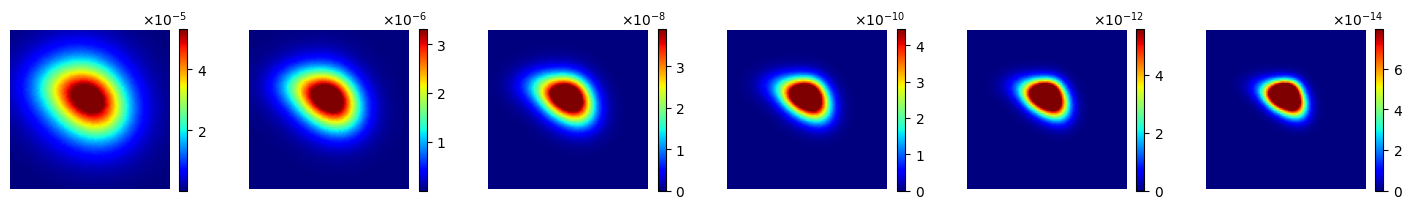

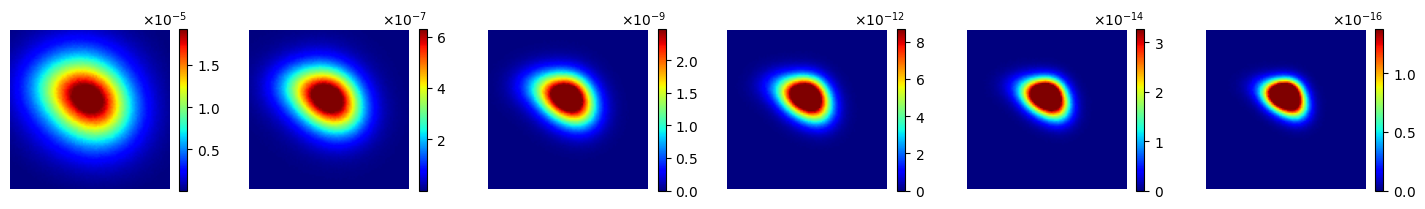

In [ ]:
#plots FL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

raw_FL = test.FL / (10**4)
save_fig = 1
save_path = os.path.join('./predictions/' + test.folder_name)

def format_ticks_with_shared_exponent(ticks):
    # Find max exponent among ticks
    exponents = [int(np.floor(np.log10(abs(t)))) if t != 0 else 0 for t in ticks]
    max_exp = max(exponents)
    
    # Format mantissas
    labels = []
    for t in ticks:
        mantissa = t / (10**max_exp)
        labels.append(f"{mantissa:.2f}")
    
    # Return labels and the shared exponent
    return labels


for x in range(test.FL.shape[0]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # Create a 1x6 grid of subplots with a specific size
    fig.subplots_adjust(wspace=0.2)
    for i in range(6):
        ax = axes[i]
        img_data = np.squeeze(raw_FL[x, :, :, i])
        vmin = np.percentile(img_data, 2.5)
        vmax = np.percentile(img_data, 97.5)
        vmid = (vmin + vmax) / 2

        img = ax.imshow(img_data, vmin=vmin, vmax=vmax, cmap='jet')
        ax.axis('off')

        cbar = fig.colorbar(img, ax=ax, shrink=0.7)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0, 0))
        
        cbar.formatter = formatter
        cbar.update_ticks()

        
        # Get the offset text string manually
        # fig.canvas.draw_idle()   # Or fig.canvas.draw() if immediate

        # offset_str = cbar.ax.yaxis.get_offset_text().get_text()
        # # Hide the original offset text

        # print("offset str: ",cbar.ax.yaxis.get_offset_text().get_text())
        # cbar.ax.yaxis.offsetText.set_visible(False)


        # Manually add offset text at a custom position (x, y) in axes coords
        # Adjust these values to move the text where you want
        # cbar.ax.text(
        #     0.95, 1.05,  # x, y coordinates in axes fraction (just right & above)
        #     offset_str,
        #     transform=cbar.ax.transAxes,
        #     fontsize=15,
        #     ha='left',
        #     va='bottom'
        # )

        # Set colorbar ticks and tick size

        # ticks = [vmin, vmid, vmax]
        # cbar.set_ticks(ticks)

        # # Manually set tick labels rounded to 1 decimal place as strings
        # tick_labels = format_ticks_with_shared_exponent(ticks)
        # #tick_labels = [format_ticks_with_shared_exponent(t) for t in ticks]
        # cbar.set_ticklabels(tick_labels)
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(tick_labels)
        # cbar.ax.tick_params(labelsize=15)


 

    #optionally, save the figures
    if save_fig:
        plot_save_path_FL = save_path + '_depth_' + str(x) +'_FL.png'
        plt.savefig(plot_save_path_FL, dpi=100, bbox_inches='tight')

    #plt.tight_layout()
    plt.show()


In [ ]:
#plots OP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Scale OP data for visualization
test.OP[:, :, :, 0] /= 10
save_fig = 1
save_path = os.path.join('./predictions/' + test.folder_name)

for x in range(test.RE.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))  # Adjusted figsize for 2 plots

    for i in range(2):
        ax = axes[i]
        img_data = np.squeeze(test.OP[x, :, :, i])
        
        # Display image with 2.5–97.5 percentile range
        img = ax.imshow(
            img_data,
            vmin=np.percentile(img_data, 2.5),
            vmax=np.percentile(img_data, 97.5),
            cmap='jet'
        )
        ax.axis('off')

        # Use ScalarFormatter for clean scientific notation
        cbar = fig.colorbar(img, ax=ax, shrink=0.8)
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-2, 2))  # Force scientific notation outside range
        cbar.formatter = formatter
        cbar.ax.yaxis.set_offset_position('left')  # Move exponent to top
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=10)

    if save_fig:
        plot_save_path_OP = save_path + '_depth_' + str(x) +'_OP.png'
        plt.savefig(plot_save_path_OP, dpi=100, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

# Scale back to original magnitude
test.OP[:, :, :, 0] *= 10


In [ ]:
test.modelD.summary()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Scale DF data (if necessary — match OP logic)

save_fig = 0
save_path = os.path.join('./predictions/' + test.folder_name)

for x in range(test.DF.shape[0]):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))  # Single plot for DF

    img_data = np.squeeze(test.DF[x, :, :])
    
    # Display image with 2.5–97.5 percentile range for contrast enhancement
    img = ax.imshow(
        img_data,
        vmin=0 ,
        vmax=15,
        cmap='jet'
    )
    ax.axis('off')

    # Add colorbar with scientific formatting
    cbar = fig.colorbar(img, ax=ax, shrink=0.8)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))
    cbar.formatter = formatter
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=10)

    if save_fig:
        plot_save_path_DF = save_path + '_depth_' + str(x) + '_DF.png'
        plt.savefig(plot_save_path_DF, dpi=100, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize fx as given
fx = [0, 0.05, 0.1, 0.15, 0.2, 0.25]

# Find the index where the maximum occurs in the last frame (i == test.FL.shape[0] - 1)
# test.FL has shape (n, m, p), where n is time, m is rows, and p is columns
last_frame = test.FL[-1]  # Get the last frame (2D array)
max_index = np.unravel_index(np.argmax(last_frame), last_frame.shape)  # Find the 2D index of the max value

# Now plot for each i, using the same max_index for each iteration
for i in range(test.FL.shape[0]):
    # Extract the data for the current iteration and the maximum index
    max_value = test.FL[i, max_index[0], max_index[1]]  # Use the max_index for the current frame
    plt.plot(fx, max_value)  # Plot using the maximum index for the current frame
    plt.ylabel('Max Fluorescence Intensity')
    plt.xlabel('Fx')
    plt.title(f'Tumour Max Intensity at pixel with max intensity for fx = 0')

plt.show()  # Display the plot after the loop finishes


In [ ]:
#analyze only the middle portion 
for i in range(test.FL.shape[0]):
    #for x in range(test.FL.shape[-1]):
    plt.plot(fx, np.mean(test.FL[i,40:60,40:60], axis = (0,1)))
    plt.ylabel('Mean Fluorescence Intensity')
    plt.xlabel('Fx')
    plt.title('Tumour 4 Mean Intensity')

In [ ]:
#analyze only the middle pixel 
for i in range(test.FL.shape[0]):
    #for x in range(test.FL.shape[-1]):
    plt.plot(fx, test.FL[i,50,50])
    plt.ylabel('Pixel Wise Intensity')
    plt.xlabel('Fx')
    plt.title('Pixel Wise Intensity')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to find the index of the minimum value in the matrix
def find_min_index(matrix):
    min_index_flat = np.argmin(matrix)  # Find the flat index of the minimum
    row, col = np.unravel_index(min_index_flat, matrix.shape)  # Convert to row, col
    return row, col

# Loop through the FL data (assuming test.FL and test.DF are 3D arrays)
for i in range(test.FL.shape[0]):
    DF = np.squeeze(test.DF[i])  # Remove single dimensions if necessary
    print("DF for index {}:".format(i), DF)
    
    # Find the row and column of the minimum value in DF
    row, col = find_min_index(DF)
    print(f"Minimum DF value at ({row}, {col}): {DF[row, col]}")
    plt.imshow(DF)
    
    # Plot the pixel intensity for the minimum DF pixel
    plt.plot(fx, test.FL[i, row, col])  # Plot intensity from the minimum DF pixel
    plt.ylabel('Pixel Wise Intensity')
    plt.xlabel('Fx')
    plt.title(f'Pixel Wise Intensity for Min DF at index {i}')
    plt.show()  # Display the plot


In [ ]:
# #obtain the onion peeler images 


# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# raw_FL = test.FL / (10**4)

# for x in range(test.FL.shape[0]):
#     fig, axes = plt.subplots(1, 6, figsize=(18, 3))  # Create a 1x6 grid of subplots with a specific size
#     for i in range(raw_FL.shape[-1]):
#         #if the first spatial frequency, plot normally 
#         ax = axes[i]  # Access each axis

#         if i == 5:
#             img_data = np.squeeze(raw_FL[x, :, :, i])
#         else:
#             img_data = np.squeeze(raw_FL[x, :, :, i] - raw_FL[x, :, :, i + 1] )

#         img = ax.imshow(
#             img_data,
#             vmin=np.percentile(img_data, 2.5),
#             vmax=np.percentile(img_data, 97.5),
#             cmap='jet'
#         )
#         ax.axis('off')  # Turn off both axes and ticks

#         # Create a colorbar with compact scientific formatting
#         cbar = fig.colorbar(img, ax=ax, shrink=0.8)
#         formatter = ticker.ScalarFormatter(useMathText=True)
#         formatter.set_powerlimits((-2, 2))  # Forces scientific notation outside this range
#         cbar.ax.yaxis.set_offset_position('left')  # Moves the offset label (e.g. ×10³) to the top
#         cbar.formatter = formatter
#         cbar.update_ticks()
#         cbar.ax.tick_params(labelsize=6)

#     plt.tight_layout()
#     plt.show()




In [ ]:
#create x-y plot with min depth of all liquid phantoms 
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
#true_DF = np.array([[0, 2, 4, 6] for x in range(4)])
#pred_DF = np.array([[-0.10, 1.93, 3.51, 7.01], [0.29, 3.21, 4.70, 6.02], [0.37, 2.05, 3.31, 4.89], [0.28, 3.07, 4.23, 5.01]])

num_depth = 9
depths = [2, 4, 6, 8]
true_DF =  []

for x in range(num_depth):
    for i in range(len(depths)):
        true_DF.append(depths[i])

true_DF = np.array(true_DF)

#pred_DF = np.array([0.79, 2.93, 6.65, 8.81, 0.31, 0.422, 3.20, 5.77, 0.64, 3.41, 6.50, 8.43, 0.53, 3.35, 6.45, 8.55, 0.78, 2.96, 3.21, 3.93, 6.41, 7.49, 9.31, 2.91, 3.44, 7.9])

#specify .txt file to extrac the min predictions 
# with open("./predictions/all_pred.txt", "r") as file:
#     pred_DF = np.array([float(line.strip()) for line in file])

#pred_DF = np.array([0.45773184, 2.0267565,  9.557396 ,  9.592601  ])
import numpy as np

pred_DF = [
    0.1525996, 0.7289649, 1.2748199, 2.128233,
    0.51240134, 0.9275158, 1.7906778, 2.4717653,
    0.14244394, 0.7205348, 1.3051715, 1.7163882,
    0.3788898, 0.7610381, 1.1452417, 1.4907708,
    0.5689748, 1.0892558, 1.8960938, 1.6412988,
    0.29827195, 0.8634385, 1.735863, 1.986697,
    0.11062625, 0.65099645, 1.3819828, 1.9619007,
    0.28777266, 0.7991585, 1.6462424, 2.1694937,
    0.27210417, 0.8024966, 1.5833259, 2.4025385
]



predict = test.modelD.predict([test.OP, test.FL], batch_size=32)

QF_P = predict[0]
DF_P = predict[1]
DFP_min = test.get_min(DF_P)

pred_DF = np.array(np.squeeze(DFP_min))



font = {'family': 'DejaVu Sans', 'weight': 'bold', 'size':20}
matplotlib.rc('font', **font)
from sklearn.metrics import r2_score
print("R2: ", r2_score(true_DF, pred_DF))

print(true_DF.shape, pred_DF.shape)
print(np.mean(np.abs(true_DF - pred_DF)))
print(np.std(np.abs(true_DF - pred_DF)))

plt.scatter(true_DF,pred_DF, s= 20, color = ['red'])
plt.plot(plt.xlim([0, 10]), plt.ylim([0, 10]),color='b', linewidth=3, linestyle='dashed')

plt.ylabel("Predicted Depth (mm)")
plt.xlabel("True Depth (mm)")
#plt.title("Minimum Margin Thickness Graph", pad = 10)
plt.tight_layout()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# True and predicted values
y_true = [5.05, 1.25, 5.45, 4.73, 6.30, 5.75]
y_pred = [4.98, 0.16, 5.38, 5.34, 4.84, 5.53]

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)

# Calculate R^2 score
r2 = r2_score(y_true, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


In [ ]:
import numpy as np

col1 = np.array([
    0.3189304, 1.0953722, 2.331614, 4.178574, 1.0134728, 0.8334494, 2.5871055,
    4.4592, 1.360114, 0.313261, 1.899353, 3.856589, 0.6510978, 0.421369,
    2.3129308, 4.3795867, 0.5526237, 0.5568495, 2.6266308, 4.5427525,
    1.4214833, 0.5011137, 2.6540146, 4.4361792, 0.9687653, 0.025397,
    2.5061357, 4.612852, 1.8862443, 0.4425926, 2.2889056, 4.02907,
    1.4007096, 0.7702587, 2.8391106, 4.5335748
])

col2 = np.array([
    1.7907168, 4.22087324, 4.6133857, 4.1332498, 1.75281742, 3.52741727,
    3.2748623, 1.0401373, 2.007962011, 4.51167476, 5.04315746, 4.2101564,
    1.62898538, 3.70922619, 4.7846155, 1.017271, 1.55620417, 3.0276584,
    0.537601, 0.9725637, 2.17890745, 3.67725557, 3.1176765, 0.9681892,
    2.23210254, 3.50419691, 5.04352087, 1.5943117, 2.39653653, 3.76157251,
    4.2863266, 0.9857931, 3.4670069, 4.26108095, 4.5298774, 2.8422027
])

col3 = np.array([
    0.7409117, 1.1335077, 0.70928, 0.132441, 0.9921083, 1.818323,
    1.6037607, 0.134954, 0.6981318, 1.0516233, 0.596757, 0.134344,
    0.46803, 1.414529, 0.715162, 0.127372, 0.9283113, 1.548626,
    1.7360554, 0.146913, 0.4200811, 1.1261687, 1.9072957, 0.136299,
    0.389918, 0.5078087, 0.476601, 0.128007, 1.274578, 1.7635,
    1.068598, 0.13119, 1.512597, 1.6401024, 1.0037923, 0.137548
])

col4 = np.array([
    0.3007855, 0.421108, 0.3083653, 0.4207683, 0.7637465, 0.7651353,
    0.992684, 1.397292, 0.4444027, 0.0597584, 0.442321, 1.08361,
    0.0467727, 0.7715886, 1.2469034, 0.09718, 0.7084808, 0.13401,
    0.083322, 0.936236, 0.396254, 0.0001347, 0.223771, 0.127542,
    0.2457942, 0.7495556, 1.3811636, 0.441216, 1.1050239, 0.7099504,
    0.4364924, 0.272291, 0.7967222, 0.7274547, 0.3883495, 0.572678
])
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from itertools import combinations

columns = [col1, col2, col3, col4]

# Add line breaks (\n) in longer labels to wrap them
names = ['ResNet', 'U-Net', 'ResNet\nwith Dropout', 'U-Net\nwith Dropout']

means = [np.mean(col) for col in columns]
stds = [np.std(col) for col in columns]

fig, ax = plt.subplots(figsize=(9, 6))  # moderate width
bars = ax.bar(names, means, yerr=stds, capsize=6, color='#4a90e2', edgecolor='black')

ax.set_ylabel('Depth Error', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep x-labels horizontal
plt.xticks(fontsize=12)

# Compute max height including error bars
y_max = max(means[i] + stds[i] for i in range(len(columns)))

# Start significance lines just above the highest error bar:
base_y = y_max + 0.5
step = 1
spacing = 0.4

comparisons = list(combinations(range(4), 2))

for idx, (i, j) in enumerate(comparisons):
    u_stat, p = mannwhitneyu(columns[i], columns[j], alternative='two-sided')

    if p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = 'ns'

    x1, x2 = i, j
    y = base_y + idx * step

    ax.plot([x1, x1, x2, x2], [y, y + spacing, y + spacing, y], lw=1.5, c='black')
    ax.text((x1 + x2) / 2, y + spacing + 0.05, sig, ha='center', va='bottom', fontsize=16)

plt.ylim(0, base_y + step * len(comparisons) + 1)
plt.xlabel('Model Type', fontsize = 20)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

col1 = np.array([
    0.3189304, 1.0953722, 2.331614, 4.178574, 1.0134728, 0.8334494, 2.5871055,
    4.4592, 1.360114, 0.313261, 1.899353, 3.856589, 0.6510978, 0.421369,
    2.3129308, 4.3795867, 0.5526237, 0.5568495, 2.6266308, 4.5427525,
    1.4214833, 0.5011137, 2.6540146, 4.4361792, 0.9687653, 0.025397,
    2.5061357, 4.612852, 1.8862443, 0.4425926, 2.2889056, 4.02907,
    1.4007096, 0.7702587, 2.8391106, 4.5335748
])

col2 = np.array([
    1.7907168, 4.22087324, 4.6133857, 4.1332498, 1.75281742, 3.52741727,
    3.2748623, 1.0401373, 2.007962011, 4.51167476, 5.04315746, 4.2101564,
    1.62898538, 3.70922619, 4.7846155, 1.017271, 1.55620417, 3.0276584,
    0.537601, 0.9725637, 2.17890745, 3.67725557, 3.1176765, 0.9681892,
    2.23210254, 3.50419691, 5.04352087, 1.5943117, 2.39653653, 3.76157251,
    4.2863266, 0.9857931, 3.4670069, 4.26108095, 4.5298774, 2.8422027
])

col3 = np.array([
    0.7409117, 1.1335077, 0.70928, 0.132441, 0.9921083, 1.818323,
    1.6037607, 0.134954, 0.6981318, 1.0516233, 0.596757, 0.134344,
    0.46803, 1.414529, 0.715162, 0.127372, 0.9283113, 1.548626,
    1.7360554, 0.146913, 0.4200811, 1.1261687, 1.9072957, 0.136299,
    0.389918, 0.5078087, 0.476601, 0.128007, 1.274578, 1.7635,
    1.068598, 0.13119, 1.512597, 1.6401024, 1.0037923, 0.137548
])

col4 = np.array([
    0.3007855, 0.421108, 0.3083653, 0.4207683, 0.7637465, 0.7651353,
    0.992684, 1.397292, 0.4444027, 0.0597584, 0.442321, 1.08361,
    0.0467727, 0.7715886, 1.2469034, 0.09718, 0.7084808, 0.13401,
    0.083322, 0.936236, 0.396254, 0.0001347, 0.223771, 0.127542,
    0.2457942, 0.7495556, 1.3811636, 0.441216, 1.1050239, 0.7099504,
    0.4364924, 0.272291, 0.7967222, 0.7274547, 0.3883495, 0.572678
])
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from itertools import combinations

columns = [col1, col2, col3, col4]

# Add line breaks (\n) in longer labels to wrap them
names = ['ResNet', 'U-Net', 'ResNet\nwith Dropout', 'U-Net\nwith Dropout']

means = [np.mean(col) for col in columns]
stds = [np.std(col) for col in columns]

fig, ax = plt.subplots(figsize=(9, 6))  # moderate width
bars = ax.bar(names, means, yerr=stds, capsize=6, color='#4a90e2', edgecolor='black')

ax.set_ylabel('Depth Error', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep x-labels horizontal
plt.xticks(fontsize=12)

# Compute max height including error bars
y_max = max(means[i] + stds[i] for i in range(len(columns)))

# Start significance lines just above the highest error bar:
base_y = y_max + 0.5
step = 1
spacing = 0.4


comparisons = list(combinations(range(4), 2))

for idx, (i, j) in enumerate(comparisons):
    t_stat, p = ttest_ind(columns[i], columns[j], equal_var=False)  # Welch's t-test

    if p < 0.001:
        sig = '***'
    elif p < 0.01:
        sig = '**'
    elif p < 0.05:
        sig = '*'
    else:
        sig = 'ns'

    x1, x2 = i, j
    y = base_y + idx * step

    ax.plot([x1, x1, x2, x2], [y, y + spacing, y + spacing, y], lw=1.5, c='black')
    ax.text((x1 + x2) / 2, y + spacing + 0.05, sig, ha='center', va='bottom', fontsize=12)

In [ ]:
# Compute mean absolute error and standard deviation at each depth
unique_depths = np.unique(true_DF)
mean_errors = []
std_errors = []

for d in unique_depths:
    indices = np.where(true_DF == d)
    depth_errors = np.abs(true_DF[indices] - pred_DF[indices])
    mean_errors.append(np.mean(depth_errors))
    std_errors.append(np.std(depth_errors))

# Create bar graph with error bars
plt.figure()
plt.bar(
    [str(d) + " mm" for d in unique_depths], 
    mean_errors, 
    yerr=std_errors, 
    capsize=5, 
    color='skyblue', 
    edgecolor='black'
)
plt.ylabel("Mean Absolute Error (mm)")
plt.xlabel("True Depth")
plt.title("Prediction Error by Depth")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)




In [ ]:
from scipy.stats import ttest_ind

# Store errors for each depth
depth_errors_dict = {}

for d in unique_depths:
    indices = np.where(true_DF == d)
    depth_errors = np.abs(true_DF[indices] - pred_DF[indices])
    depth_errors_dict[d] = depth_errors


In [ ]:
from itertools import combinations

# Store results
ttest_results = []

for d1, d2 in combinations(unique_depths, 2):
    errors1 = depth_errors_dict[d1]
    errors2 = depth_errors_dict[d2]
    stat, p_val = ttest_ind(errors1, errors2, equal_var=False)  # Welch’s t-test is safer
    ttest_results.append({
        'depth_pair': (d1, d2),
        't_statistic': stat,
        'p_value': p_val
    })


In [ ]:
print("Pairwise t-tests between depth errors:")
for result in ttest_results:
    d1, d2 = result['depth_pair']
    p_val = result['p_value']
    significance = "✓" if p_val < 0.05 else "✗"
    print(f"{d1} mm vs {d2} mm: p = {p_val:.4f} {significance}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load predictions from file
with open("./predictions/all_pred.txt", "r") as file:
    pred_DF = np.array([float(line.strip()) for line in file])

# Prepare ground truth
num_depth = 9
depths = [2, 4, 6, 8]
num_cases = num_depth
true_DF = np.tile(depths, num_cases)  # shape: (num_cases * 4,)
true_DF = true_DF.reshape((num_cases, len(depths)))
pred_DF = pred_DF.reshape((num_cases, len(depths)))

# Compute absolute error
errors = np.abs(true_DF - pred_DF)

# Plot bar graph for each case
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axs = axs.flatten()

for i in range(num_cases):
    axs[i].bar([str(d) for d in depths], errors[i], color='skyblue', edgecolor='black')
    axs[i].set_ylim(0, np.max(errors) + 1)
    axs[i].set_title(f"Case {i+1}")
    axs[i].set_xlabel("Depth (mm)")
    axs[i].set_ylabel("Error (mm)")

plt.suptitle("Depth-wise Prediction Error for Each Case", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load predictions
with open("./predictions/all_pred.txt", "r") as file:
    pred_DF = np.array([float(line.strip()) for line in file])

# Prepare true depths
num_depth = 9
depths = [2, 4, 6, 8]
num_cases = num_depth
true_DF = np.tile(depths, num_cases).reshape((num_cases, len(depths)))
pred_DF = pred_DF.reshape((num_cases, len(depths)))

# Compute absolute error
errors = np.abs(true_DF - pred_DF)

# Compute mean and std for each case
mean_errors = np.mean(errors, axis=1)
std_errors = np.std(errors, axis=1)

# Plot mean errors with error bars
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_cases + 1), mean_errors, yerr=std_errors, capsize=5, 
        color='steelblue', edgecolor='black', error_kw={'elinewidth':1.5})
plt.xticks(range(1, num_cases + 1))
plt.xlabel("Case Number")
plt.ylabel("Mean Absolute Error (mm)")
plt.title("Mean Prediction Error for Each Case", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize fx as given
fx = [1, 2, 3, 4, 5, 6]  # Placeholder, will be mapped to your custom labels

# Custom x-axis labels
custom_labels = [0, 0.0140, 0.0240, 0.0390, 0.068, 0.2]

# Find the index where the maximum occurs in the last frame (i == test.FL.shape[0] - 1)
# test.FL has shape (n, m, p), where n is time, m is rows, and p is columns
last_frame = test.FL[-1]  # Get the last frame (2D array)
max_index = np.unravel_index(np.argmax(last_frame), last_frame.shape)  # Find the 2D index of the max value

# Now plot for each i, using the same max_index for each iteration
for i in range(test.FL.shape[0]):
    # Extract the data for the current iteration and the maximum index
    max_value = test.FL[i, max_index[0], max_index[1]]  # Use the max_index for the current frame
    plt.plot(fx, max_value)  # Plot using the maximum index for the current frame
    plt.ylabel('Max Fluorescence Intensity')
    plt.xlabel('Fx')
    plt.title(f'Tumour Max Intensity at pixel with max intensity for fx = 0')

# Set custom labels for x-axis
plt.xticks(fx, custom_labels)

# Show the plot
plt.show()  # Display the plot after the loop finishes
